# Notebook om een dataset voor lcda te genereren en analyses hierop te doen

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, make_scorer, confusion_matrix, classification_report, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import itertools

import statsmodels.api as sm

In [2]:
# met de magic-commando's hieronder werken de wijzigingen die je in .py-files doet het 
# meteen in je notebook. Dan hoef je het notebook niet te herstarten.
%load_ext autoreload

%autoreload 2

In [3]:
#toon alle kolommen
pd.set_option('display.max_columns', None)
#toon alle rijen
pd.set_option('display.max_rows', None)

# Data 1cijferHO
1. Nodig voor kolom GemEindcijferVoVanDeHoogsteVooroplVoorHetHo
1. Koppel aan studentnummer

In [4]:
from functies import koppel_1cho_stnr

# df met studentnummer en gemiddeld cijfer vooropleiding
df_stnr_gemcijfer = koppel_1cho_stnr()

# Data Osiris
1. Nodig voor studentkenmerken en info m.b.t. inschrijvingen
1. Data start bij collegejaar 2012, hiervoor is geen inschrijvingsdata en studievoortgang beschikbaar (selecteer later studenten met AanvangsjaarOpleiding >= 2012)

In [5]:
from functies import bewerk_osiris_data

# df met achtergrondkenmerken studenten en langstudeerderinfo etc.
df_osiris = bewerk_osiris_data(df_stnr_gemcijfer)

# Data studievoortgang
1. Nodig voor EC's
1. Koppel aan alle voorgaande data
1. Bevat 5 regels per student per collegejaar (voor elke periode 1 regel), wordt later gereduceerd tot 1 regel

In [6]:
from functies import koppel_sv_osiris

# df met toegevoegde studievoortgang (EC's), diploma's etc.
df_sv = koppel_sv_osiris(df_osiris)

# Databewerking
1. Filter op voltijd bachelorstudenten
1. Vanaf verblijfsjaar 2012 (daarvoor geen data m.b.t. studievoortgang)
1. Let op! Allen propedeuseinstroom meegenomen
1. EERSTEJAARS DIE EEN HOGEREJAARSVERZOEK HEBBEN GEDAAN ER OOK UITFILTEREN?
    1. Gaat bijv. om Verpleegkunde doorstroomroute (dat nog niet zo genoemd werd)
    1. BML en Chemiestudenten vallen hier ook onder
    1. Dit verzoek hoeft niet gehonoreerd te zijn (meen ik)
1. WAT TE DOEN MET Tweedegraads Leraar Omgangskunde ? Veel studenten met >100 EC in P1 jaar 1.
1. WAT TE DOEN MET APAB? UNI CIJFERS WORDEN ALS VRIJSTELLING GEZIEN, KAN ONDERSCHATTING GEVEN.
1. Verblijfsjaar wordt bepaald op opleidingsniveau. Een switch tussen opleidingen en zelfs tussen PB en PBFL (dezelfde croho) doet de teller opnieuw starten
1. Het bekostigingsplaatje wordt dus niet helemaal in kaart gebracht. Dit is ook ingewikkeld, omdat we niet weten hoeveel jaar er bijv. bij andere HBO/WO instellingen is gestudeerd.
1. Gecorrigeerde kolommen voor langstudeerder toch niet meegenomen, omdat dit bij andere instellingen niet zomaar gereproduceerd kan worden (mits ze IndicatieActiefOpPeildatum kolommen hebben)

In [7]:
from functies import data_bewerking

# df met alle benodigde data
# df_ruw om plaatjes over langstudeerders binnen een jaar te maken
# df om analyses mee uit te voeren (op D instroom gefilterd)
df_ruw, df = data_bewerking(df_sv)

# Opslaan dataset

1. Sla df_ruw niet op i.v.m. studentnummers (deze is om lokaal te visualiseren niet om te delen)

In [8]:
# sla dataset op
# df.to_feather(r'Z:\maarten-lcda\dataset\HLdata220518.feather')

# Info



In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79510 entries, 0 to 79509
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      79510 non-null  int32  
 1   Geslacht                79510 non-null  object 
 2   Leeftijd                79510 non-null  int64  
 3   Vooropleiding           79510 non-null  object 
 4   VooropleidingBRIN4      78631 non-null  object 
 5   VooropleidingPC4        78465 non-null  object 
 6   VooropleidingGemCijfer  53244 non-null  float64
 7   DagenTotIngangsdatum    79510 non-null  int64  
 8   AanvangsjaarOpleiding   79510 non-null  int64  
 9   Collegejaar             79510 non-null  int64  
 10  VerblijfsjaarOpleiding  79510 non-null  int64  
 11  Langstudeerder5         79510 non-null  int32  
 12  Langstudeerder6         79510 non-null  int32  
 13  WordtLangstudeerder5    41105 non-null  object 
 14  WordtLangstudeerder6    37904 non-null

In [10]:
df.describe(include = 'all')

,ID,Geslacht,Leeftijd,Vooropleiding,VooropleidingBRIN4,VooropleidingPC4,VooropleidingGemCijfer,DagenTotIngangsdatum,AanvangsjaarOpleiding,Collegejaar,VerblijfsjaarOpleiding,Langstudeerder5,Langstudeerder6,WordtLangstudeerder5,WordtLangstudeerder6,CrohoActueel,NaamOpleiding,Faculteit,StatusJaarLater,Pin1,Din4,Din5,DinJaarX,MaandentotD,ECtmP1,ECtmP2,ECtmP3,ECtmP4,ECtmP5,ECGeenVrijtmP1,ECGeenVrijtmP2,ECGeenVrijtmP3,ECGeenVrijtmP4,ECGeenVrijtmP5
count,79510.000000,79510,79510.000000,79510,78631,78465,53244.000000,79510.000000,79510.000000,79510.000000,79510.000000,79510.000000,79510.000000,41105.0,37904.0,79510,79510,79510,79510,79510.000000,79510.000000,79510.000000,33110.000000,33110.000000,79510.000000,79510.000000,79510.000000,79510.000000,79510.00000,79510.000000,79510.000000,79510.000000,79510.000000,79510.000000
unique,NaN,2,NaN,4,644,571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,22,27,5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,vrouw,NaN,havo,25LN,2321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,34808,Verpleegkunde,Management en Bedrijf,herinschrijving bij dezelfde opleiding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,50652,NaN,50491,4298,7620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23523.0,27480.0,8337,7911,24005,47766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,19329.886216,NaN,20.621167,NaN,NaN,NaN,65.431429,108.481248,2016.025934,2017.352811,2.326877,0.085914,0.033103,NaN,NaN,NaN,NaN,NaN,NaN,0.369878,0.221129,0.345617,4.702205,53.152519,6.966734,17.741738,23.919107,37.034495,38.82205,6.534134,17.249928,23.394389,36.333276,37.893394
std,8850.082665,NaN,3.004585,NaN,NaN,NaN,4.286840,69.090365,2.643648,2.633353,1.471674,0.280238,0.178906,NaN,NaN,NaN,NaN,NaN,NaN,0.482774,0.415010,0.475572,1.030006,11.446009,9.155035,13.070208,18.088771,25.979026,26.74743,6.150530,11.091568,16.508504,24.619843,25.304161
min,0.000000,NaN,16.000000,NaN,NaN,NaN,57.000000,-590.000000,2012.000000,2012.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,1.000000,10.185014,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12049.000000,NaN,19.000000,NaN,NaN,NaN,62.000000,58.000000,2014.000000,2015.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,4.000000,45.963983,1.000000,8.000000,6.000000,10.000000,11.00000,1.000000,8.000000,6.000000,10.000000,10.500000
50%,18831.500000,NaN,20.000000,NaN,NaN,NaN,65.000000,92.000000,2016.000000,2018.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,4.000000,47.902421,6.000000,19.000000,28.000000,45.000000,49.13000,6.000000,18.500000,28.000000,44.000000,48.000000
75%,26372.750000,NaN,22.000000,NaN,NaN,NaN,68.000000,145.000000,2018.000000,2020.000000,3.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,1.000000,5.000000,57.988870,11.000000,26.000000,36.500000,59.000000,60.00000,10.500000,26.000000,36.000000,59.000000,60.000000


# Visualisatie langstudeerders met df_ruw

1. Hier zitten per collegejaar studenten van alle aanvangsjaren in (dus ook in 2012)
1. Geen filter op D instroom (omdat data bij collegejaar 2012 start zou je daarmee studenten die voor 2012 starten verliezen)
1. Percentage eerstejaars die langstudeer worden

In [11]:
#Layout figuren:
plt.rcParams['figure.facecolor'] = 'w' #kleur om plot heen
plt.rcParams['axes.facecolor'] = 'w' #kleur in plot
#Grid
plt.rcParams['axes.grid'] = True #verwijder grid indien False
plt.rcParams['axes.grid.axis'] = 'y' #indien axes.grid = True, toon alleen y-as grid
plt.rcParams['grid.color'] = 'k' #indien axes.grid = True
plt.rcParams['grid.alpha'] = 0.1 #indien axes.grid = True
#Frame
plt.rcParams['axes.edgecolor'] = '#23114c' #Opaque Caché
plt.rcParams['axes.linewidth'] = 1.5 #dikte frame
plt.rcParams['axes.spines.top'] = False #Verwijder bovenkant frame
plt.rcParams['axes.spines.right'] = False #Verwijder rechterkant frame
#Ticks
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
#Labels
plt.rcParams['xtick.labelsize'] = 'x-large'
plt.rcParams['xtick.color'] = '#23114c' #Opaque Caché
plt.rcParams['ytick.labelsize'] = 'x-large'
plt.rcParams['ytick.color'] = '#23114c' #Opaque Caché
plt.rcParams['legend.fontsize'] = 'xx-large'
plt.rcParams['legend.title_fontsize'] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlecolor'] = '#20BDBA' #Turquoise
plt.rcParams['axes.labelsize'] = 'xx-large'
plt.rcParams['axes.labelcolor'] = '#23114c' #Opaque Caché
plt.rcParams['text.color'] = '#23114c' #Opaque Caché
#Font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Verdana'] #of Source Sans Pro?
#Lijnen
plt.rcParams['lines.linewidth'] = 3 #lijnen in de plot

#parameters figuren functies
height = 5.5
titlesize = 21
fontsize = 13
titelhoogte = 1.08
ytext = 10

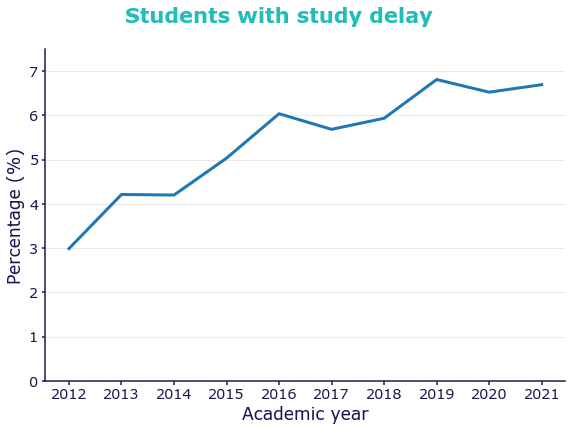

In [12]:
df_lang = df_ruw.groupby('Collegejaar').Langstudeerder6.value_counts(normalize = True).rename('Percentage').mul(100).reset_index()
df_lang = df_lang[df_lang.Langstudeerder6 == 1]

from functies import plot_langstudeerders
plot_langstudeerders(df_lang, 'Students with study delay')

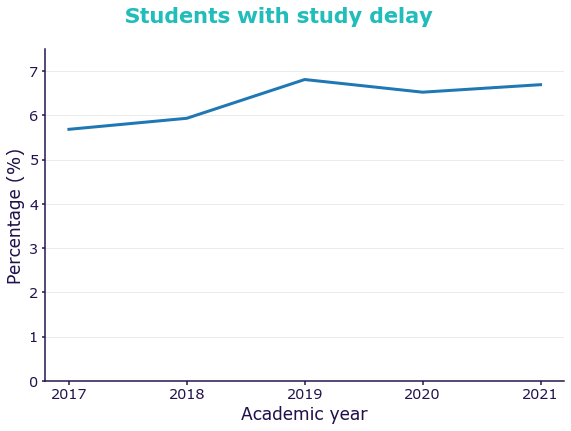

In [13]:
df_lang = df_ruw.groupby('Collegejaar').Langstudeerder6.value_counts(normalize = True).rename('Percentage').mul(100).reset_index()
df_lang = df_lang[df_lang.Langstudeerder6 == 1]
# alleen studenten in 2012 t/m 2016 zijn begonnen, dus vanaf 2017 t/m 2021 langstudeerder kunnen worden
df_lang = df_lang[df_lang.Collegejaar >= 2017]
from functies import plot_langstudeerders
plot_langstudeerders(df_lang, 'Students with study delay')

#### Eerstejaars

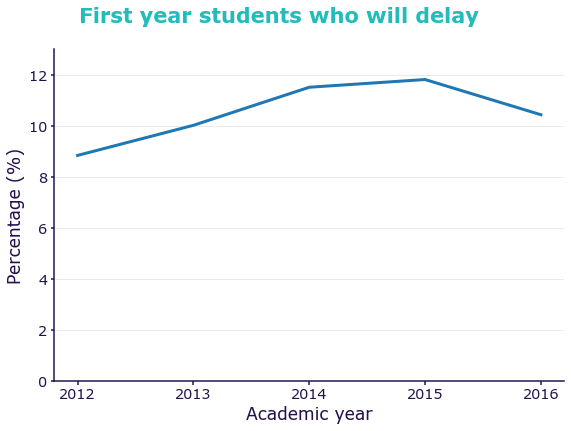

In [14]:
df_eerstejaars_lang = df_ruw[df_ruw.VerblijfsjaarOpleiding == 1].groupby('Collegejaar').WordtLangstudeerder6.value_counts(dropna = False, normalize = True).rename('Percentage').mul(100).reset_index()
df_eerstejaars_lang = df_eerstejaars_lang[df_eerstejaars_lang.WordtLangstudeerder6 == 1]

from functies import plot_langstudeerders
plot_langstudeerders(df_eerstejaars_lang, 'First year students who will delay')

# Analyse 

1. Om een dataset te maken die als model gebruikt kan worden moet je eerst type langstudeerder (bij 5 of 6 jaar studeren?) en eerstejaars selecteren, bijv door:
1. model = df[(df.VerblijfsjaarOpleiding == 1) & (df.WordtLangstudeerder6.isin([0, 1]))].copy() # of eerst iets met dropna op die specifieke langstudeerder kolom
1. LET OP! TUSSENTIJDSE UITVALLERS VALLEN WEG EN ALS JE VERVOLGENS VAN 2021 VOORSPELT WIE LANGSTUDEERDER WORDT DAN DEEL JE TOEKOMSTIGE TUSSENTIJDSE UITVALLERS OOK IN
1. VERWIJDER 2017 en 2018, omdat hier mogelijk Din5 bekend is, maar WordtLangstudeerder = 1 niet, dus inclusie zorgt voor BIAS

In [15]:
df_model = df[(df.Collegejaar.isin(range(2012, 2017))) & (df.VerblijfsjaarOpleiding == 1) & (df.WordtLangstudeerder6.isin([0, 1]))].copy()
df_model.Collegejaar.value_counts().sort_index()

2012    1307
2013    1490
2014    1534
2015    1457
2016    1525
Name: Collegejaar, dtype: int64

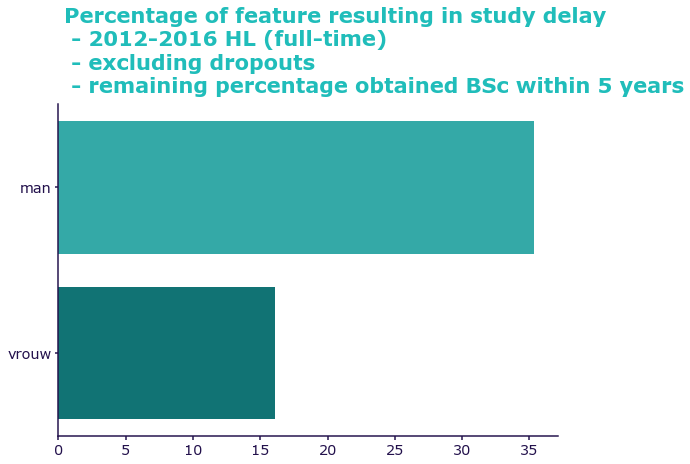

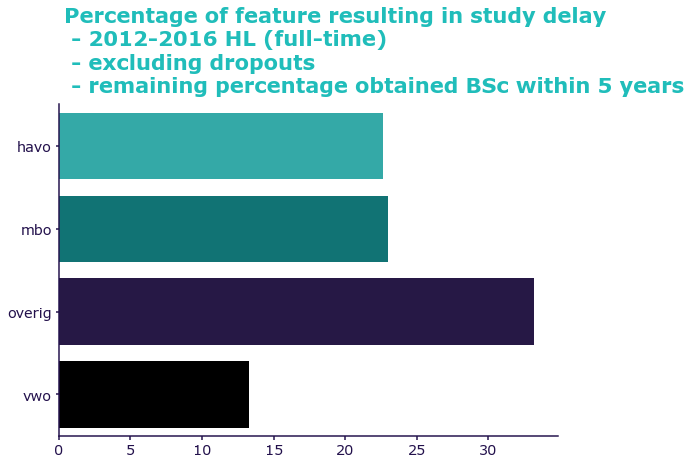

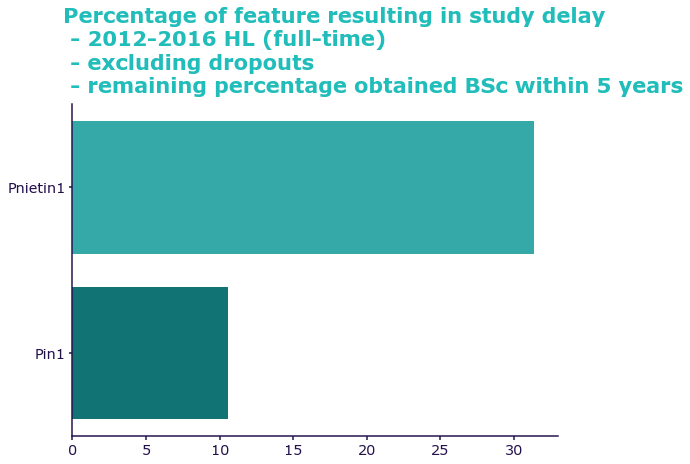

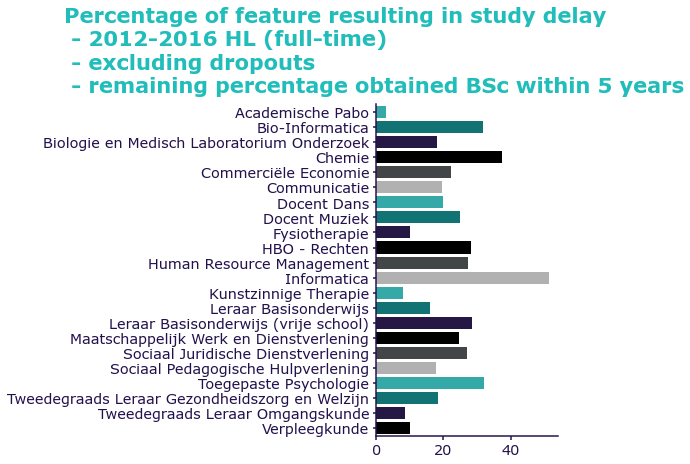

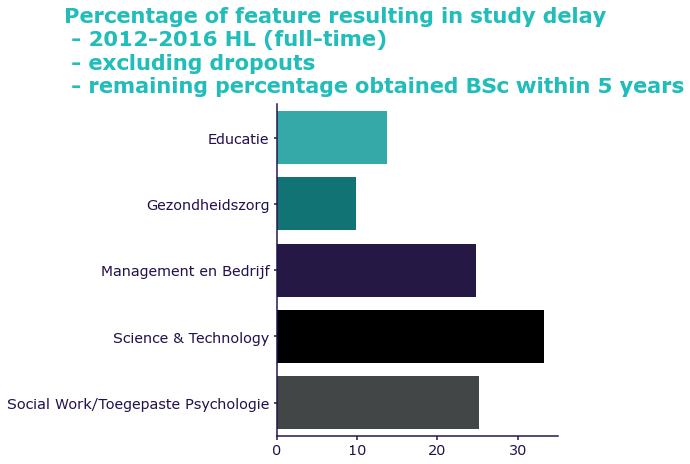

In [16]:
categorische_kenmerken = ['Geslacht', 'Vooropleiding', 'Pin1',
                          #'VooropleidingBRIN4', 'VooropleidingPC4', 
                          'NaamOpleiding', 'Faculteit']

from functies import plot_cat_kenmerken

for kenmerk in categorische_kenmerken:  
    df_kenmerk = df_model.groupby(kenmerk).WordtLangstudeerder6.value_counts(normalize = True).rename('Percentage').mul(100).reset_index()
    # Vervang voor het 0 en 1 in strings, doe je dit niet, dan ziet de bar graph er gek uit en is die lastig te interpreteren
    if kenmerk == 'Pin1':
        df_kenmerk['Pin1'].replace({0: 'Pnietin1', 1: 'Pin1'}, inplace = True)    
   
    df_kenmerk = df_kenmerk[df_kenmerk.WordtLangstudeerder6 == 1].copy()
    plot_cat_kenmerken(df_kenmerk, kenmerk, titel = 'Percentage of feature resulting in study delay\n - 2012-2016 HL (full-time) \n - excluding dropouts \n - remaining percentage obtained BSc within 5 years')

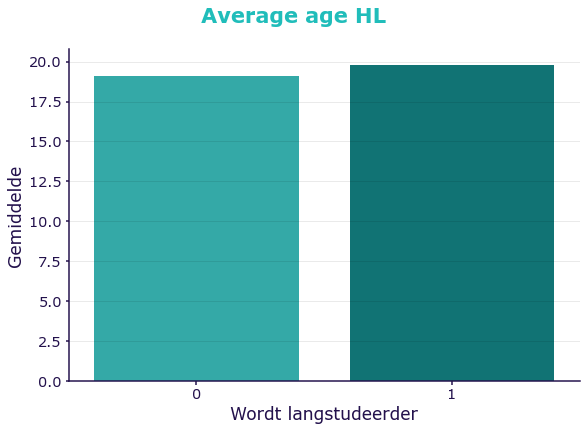

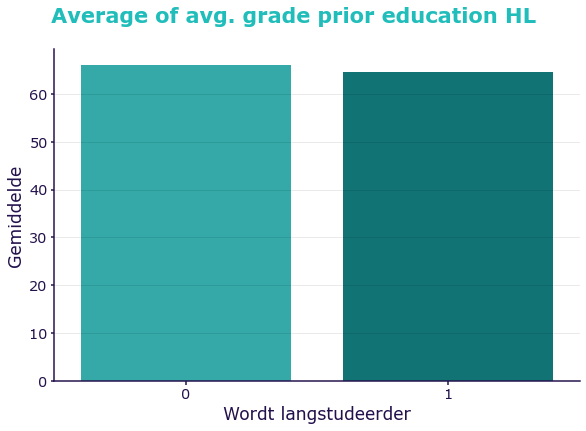

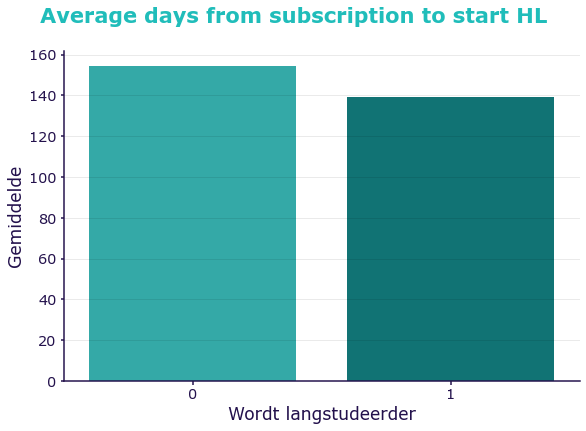

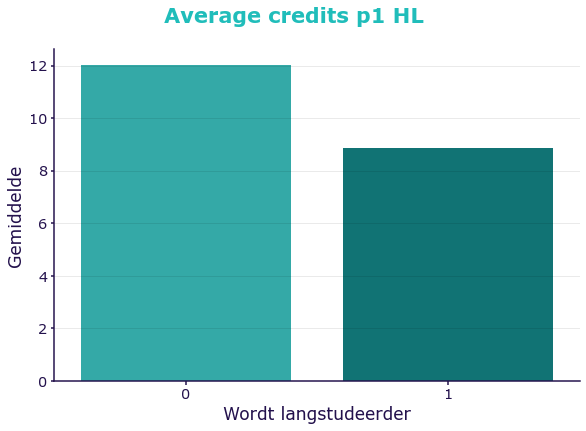

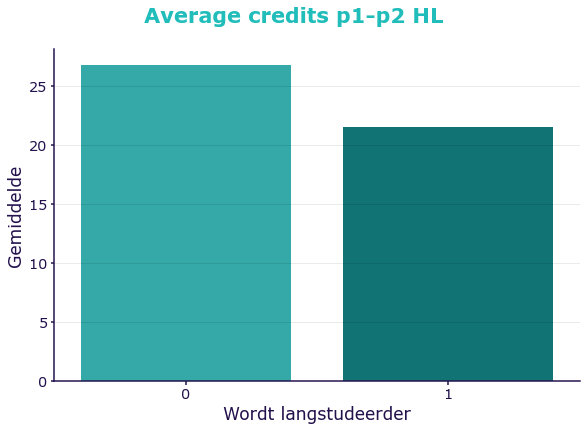

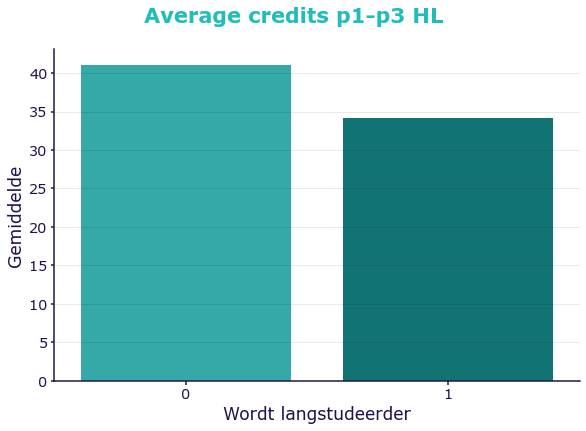

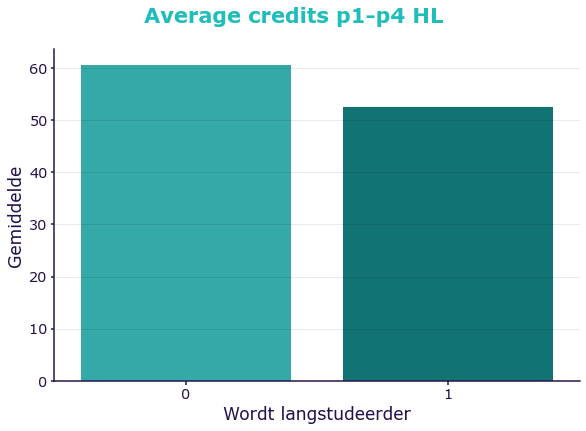

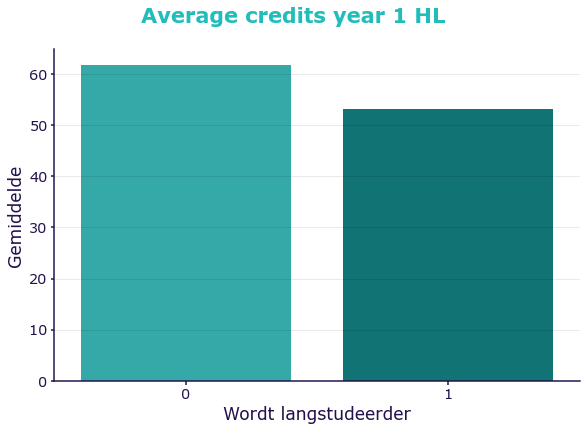

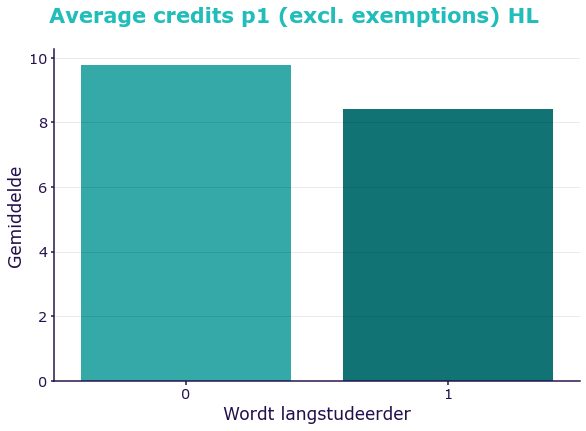

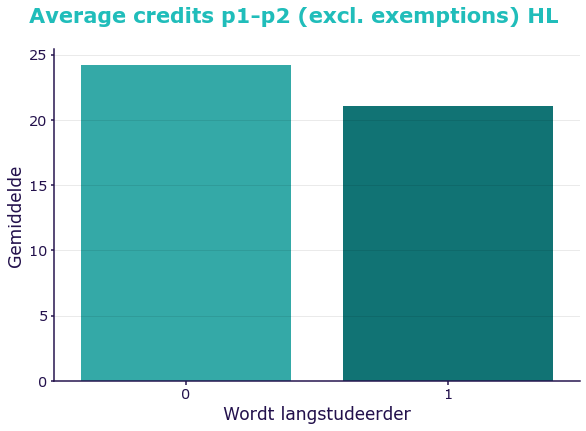

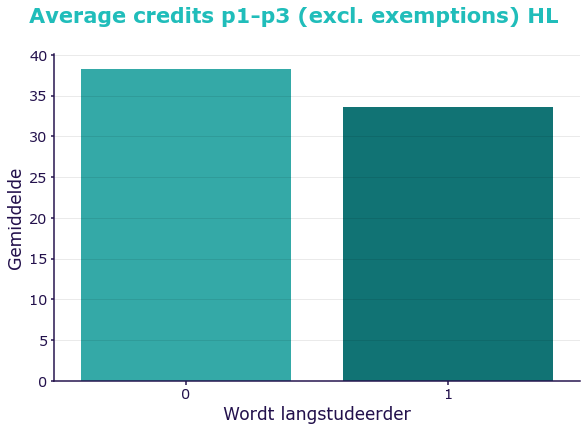

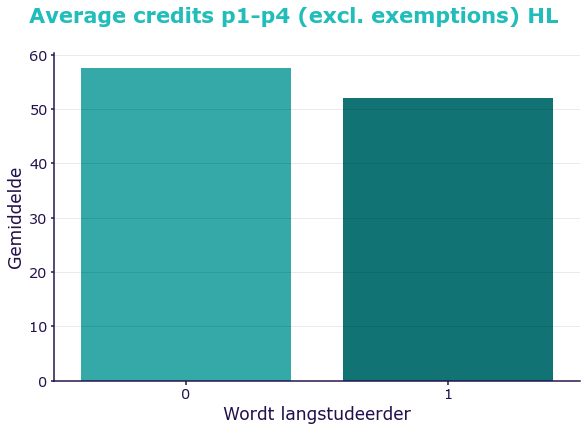

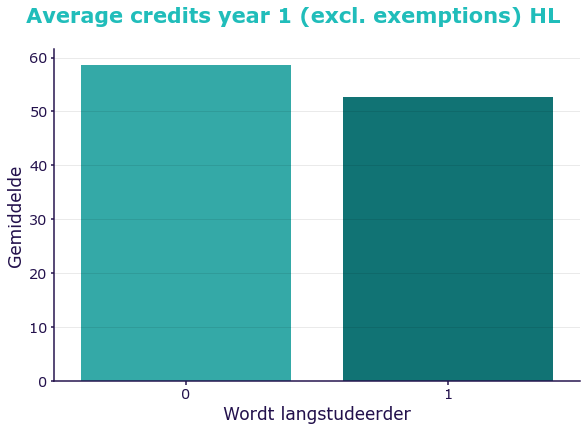

In [17]:
numerieke_kenmerken = ['Leeftijd', 'VooropleidingGemCijfer', 'DagenTotIngangsdatum',
       'ECtmP1', 'ECtmP2', 'ECtmP3', 'ECtmP4', 'ECtmP5', 'ECGeenVrijtmP1',
       'ECGeenVrijtmP2', 'ECGeenVrijtmP3', 'ECGeenVrijtmP4', 'ECGeenVrijtmP5']

features = ['age', 'of avg. grade prior education', 'days from subscription to start',
       'credits p1', 'credits p1-p2', 'credits p1-p3', 'credits p1-p4', 'credits year 1', 'credits p1 (excl. exemptions)',
       'credits p1-p2 (excl. exemptions)', 'credits p1-p3 (excl. exemptions)', 'credits p1-p4 (excl. exemptions)', 'credits year 1 (excl. exemptions)']

from functies import plot_num_kenmerken

for kenmerk, feature in zip(numerieke_kenmerken, features):  
    df_kenmerk = df_model.groupby('WordtLangstudeerder6')[kenmerk].mean().reset_index()
    plot_num_kenmerken(df_kenmerk, kenmerk, feature, titel = 'Average {} HL'.format(feature))

# Kenmerken selecteren en label maken

In [18]:
kenmerken = [#'ID',
'Geslacht',
'Leeftijd',
'Vooropleiding',
'VooropleidingBRIN4',
'VooropleidingPC4',
'VooropleidingGemCijfer',
'DagenTotIngangsdatum',
#'AanvangsjaarOpleiding',
#'Collegejaar',
#'VerblijfsjaarOpleiding',
#'Langstudeerder5',
#'Langstudeerder6',
#'WordtLangstudeerder5',
#'WordtLangstudeerder6',
#'CrohoActueel',
'NaamOpleiding',
'Faculteit',
#'StatusJaarLater',
'Pin1',
# 'Din4',
# 'Din5',
# 'DinJaarX',
# 'MaandentotD',
# 'ECtmP1',
# 'ECtmP2',
# 'ECtmP3',
# 'ECtmP4',
 'ECtmP5',
# 'ECGeenVrijtmP1',
# 'ECGeenVrijtmP2',
# 'ECGeenVrijtmP3',
# 'ECGeenVrijtmP4',
# 'ECGeenVrijtmP5'
]

In [19]:
#maak df met alle kenmerken
df_kenmerken = df_model[kenmerken].copy()

### Kenmerken numeriek maken + NaNs verwijderen indien nodig
1. Kan in sklearn model met encoders, maar voor statsmodels moet dat eerder
1. of df = pd.get_dummies(df, columns=['team'], drop_first=True) ?

In [20]:
kenmerken_string = ['Geslacht', 'Vooropleiding', 
                    'VooropleidingBRIN4', 'VooropleidingPC4', 
                    'NaamOpleiding', 'Faculteit']
# vervang alle strings door numerieke waarden van 0 t/m aantal waarden - 1. Faculteit bevat 5 faculteiten, deze worden vervangen door numerieke waarden 0 t/m 4.
# De NaNs bij VooropleidingBRIN4 en PC4 worden nu dus samen 'gecategoriseerd' als -1
for kolom in kenmerken_string:
    df_kenmerken[kolom] = df_kenmerken[kolom].astype('category').cat.codes #None en NaN wordt door -1 vervangen

#### kolom met gem cijfer vooropleiding

In [21]:
# vervang NaNs door het gemiddelde van gemiddelde cijfer vooropleiding
gem_cijfer = df_kenmerken['VooropleidingGemCijfer'].mean()
df_kenmerken['VooropleidingGemCijfer'].fillna(gem_cijfer, inplace = True)

In [22]:
label = ['WordtLangstudeerder6']

df_label = df_model[label].copy()
df_label = df_label.astype(int)
# let op, dit percentage is lager dat 20% (eerder figuur), omdat in deze set studenten van 2017 en 2018 zitten die hun diploma
# hebben gehaald en dus als WordtLangstudeerder6 zijn geclassificeerd (wellicht filteren op 2012 t/m 2016?
df_label.WordtLangstudeerder6.value_counts(normalize = True).mul(100) 

0    77.875017
1    22.124983
Name: WordtLangstudeerder6, dtype: float64

# Normaliseren (heeft zover ik heb gezien weinig effect)

In [23]:
# normaliseer (kies methode, er zijn er meer)

# mean normalization
# df_kenmerken = (df_kenmerken - df_kenmerken.mean()) / df_kenmerken.std() 

# min - max
# df_kenmerken = (df_kenmerken - df_kenmerken.min()) / (df_kenmerken.max() - df_kenmerken.min())

# Correlatie tussen kenmerken

In [24]:
df_totaal = df_kenmerken.copy()
df_totaal["WordtLangstudeerder6"] = df_label.values
df_totaal.corr()

,Geslacht,Leeftijd,Vooropleiding,VooropleidingBRIN4,VooropleidingPC4,VooropleidingGemCijfer,DagenTotIngangsdatum,NaamOpleiding,Faculteit,Pin1,ECtmP5,WordtLangstudeerder6
Geslacht,1.000000,-0.110999,0.018274,-0.048818,0.070957,0.058639,0.113183,0.246699,-0.142662,0.088972,0.063316,-0.214760
Leeftijd,-0.110999,1.000000,0.276640,0.250993,0.017608,-0.040604,-0.202592,0.098291,-0.045723,-0.016675,0.260367,0.106117
Vooropleiding,0.018274,0.276640,1.000000,0.152178,0.066454,0.020011,-0.115061,-0.096939,-0.177243,0.089809,0.098806,-0.045685
VooropleidingBRIN4,-0.048818,0.250993,0.152178,1.000000,-0.092300,-0.022605,-0.024917,0.051835,0.059224,-0.061159,0.065643,0.067681
VooropleidingPC4,0.070957,0.017608,0.066454,-0.092300,1.000000,0.049965,-0.026634,0.028519,-0.038907,0.006470,0.018587,-0.019994
VooropleidingGemCijfer,0.058639,-0.040604,0.020011,-0.022605,0.049965,1.000000,0.104834,-0.099631,-0.018014,0.218205,0.039955,-0.102091
DagenTotIngangsdatum,0.113183,-0.202592,-0.115061,-0.024917,-0.026634,0.104834,1.000000,0.051444,0.059266,0.098523,-0.080363,-0.093876
NaamOpleiding,0.246699,0.098291,-0.096939,0.051835,0.028519,-0.099631,0.051444,1.000000,-0.028696,0.041989,0.160237,-0.027556
Faculteit,-0.142662,-0.045723,-0.177243,0.059224,-0.038907,-0.018014,0.059266,-0.028696,1.000000,-0.000997,-0.137496,0.150430
Pin1,0.088972,-0.016675,0.089809,-0.061159,0.006470,0.218205,0.098523,0.041989,-0.000997,1.000000,0.265669,-0.249211


# Statsmodels

1. Welke kenmerken dragen bij aan het worden van een langstudeerder?

In [25]:
#intercept toevoegen
X = sm.add_constant(df_kenmerken)
est = sm.Logit(df_label, X)
print(est.fit(maxiter = 600).summary())

Optimization terminated successfully.
         Current function value: 0.447717
         Iterations 8
                            Logit Regression Results                            
Dep. Variable:     WordtLangstudeerder6   No. Observations:                 7313
Model:                            Logit   Df Residuals:                     7301
Method:                             MLE   Df Model:                           11
Date:                  Wed, 22 Jun 2022   Pseudo R-squ.:                  0.1528
Time:                          14:10:56   Log-Likelihood:                -3274.2
converged:                         True   LL-Null:                       -3864.8
Covariance Type:              nonrobust   LLR p-value:                1.725e-246
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.8182      0.708      2.569      0.010  

# Sklearn modellen achter elkaar

In [26]:
estimators = [LogisticRegression(max_iter = 600), 
              GradientBoostingClassifier(random_state = 14), 
              RandomForestClassifier(random_state = 14), 
              AdaBoostClassifier(random_state = 14), 
              KNeighborsClassifier(), 
              DecisionTreeClassifier(random_state = 14), 
              #GaussianProcessClassifier(), 
              MLPClassifier(), 
              #SVC(probability = True), 
              GaussianNB(),
              QuadraticDiscriminantAnalysis()]

name_estimators = ["LogisticRegression",
                   "GradientBoostingClassifier",
                   "RandomForestClassifier",
                   "AdaBoostClassifier",
                   "KNeighborsClassifier",
                   "DecisionTreeClassifier",
                   #"GaussianProcessClassifier",
                   "MLPClassifier",
                   #"SVC",
                   "GaussianNB",
                   "QuadraticDiscriminantAnalysis"]

#### Per model plotjes en parameters

Estimator LogisticRegression
waargenomen [0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 1 0]
voorspelling [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
probability [0.   0.1  0.01 0.06 0.09 0.24 0.31 0.64 0.3  0.45 0.48 0.12 0.07 0.17
 0.19 0.11 0.24 0.11 0.29 0.41]


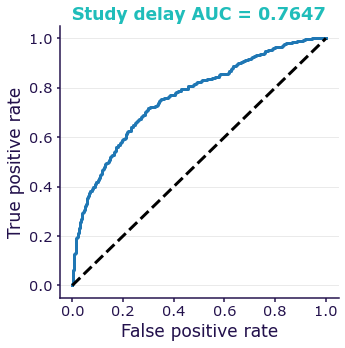

Accuracy score train: 0.7981196581196581
Accuracy score test: 0.8174982911825017
Roc auc score (op y_pred_proba): 0.7646736380502615
Roc auc score (op y_pred): 0.6165584415584415
Confusion matrix, without normalization
[[  83  225]
 [  42 1113]]


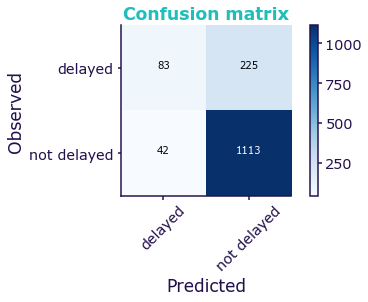

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1155
           1       0.66      0.27      0.38       308

    accuracy                           0.82      1463
   macro avg       0.75      0.62      0.64      1463
weighted avg       0.80      0.82      0.79      1463



Estimator GradientBoostingClassifier
waargenomen [0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 1 0]
voorspelling [0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0]
probability [0.06 0.14 0.12 0.04 0.15 0.21 0.38 0.73 0.21 0.68 0.3  0.11 0.12 0.16
 0.1  0.09 0.33 0.11 0.36 0.43]


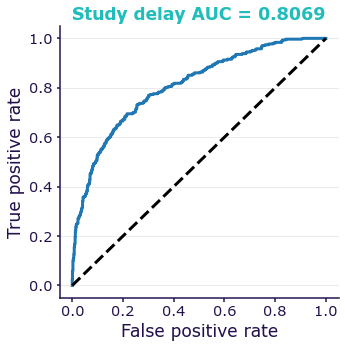

Accuracy score train: 0.8357264957264957
Accuracy score test: 0.8291182501708817
Roc auc score (op y_pred_proba): 0.8069235958846349
Roc auc score (op y_pred): 0.6560606060606061
Confusion matrix, without normalization
[[ 110  198]
 [  52 1103]]


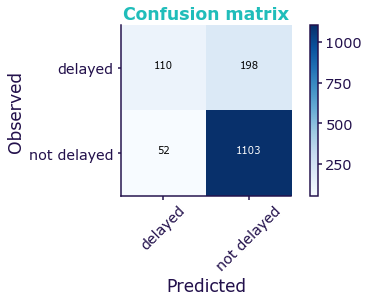

              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1155
           1       0.68      0.36      0.47       308

    accuracy                           0.83      1463
   macro avg       0.76      0.66      0.68      1463
weighted avg       0.81      0.83      0.81      1463



Estimator RandomForestClassifier
waargenomen [0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 1 0]
voorspelling [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1]
probability [0.07 0.05 0.08 0.   0.19 0.13 0.37 0.5  0.38 0.67 0.34 0.1  0.09 0.15
 0.08 0.17 0.52 0.26 0.48 0.56]


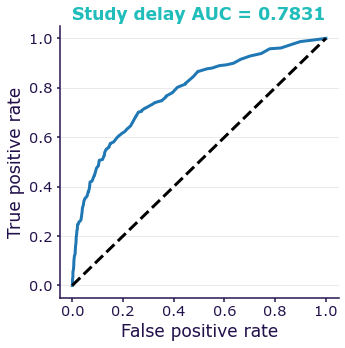

Accuracy score train: 0.9994871794871795
Accuracy score test: 0.8195488721804511
Roc auc score (op y_pred_proba): 0.7831042334289088
Roc auc score (op y_pred): 0.6511904761904762
Confusion matrix, without normalization
[[ 111  197]
 [  67 1088]]


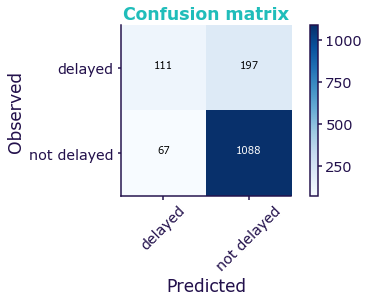

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      1155
           1       0.62      0.36      0.46       308

    accuracy                           0.82      1463
   macro avg       0.74      0.65      0.67      1463
weighted avg       0.80      0.82      0.80      1463



Estimator AdaBoostClassifier
waargenomen [0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 1 0]
voorspelling [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
probability [0.32 0.49 0.49 0.48 0.49 0.49 0.5  0.51 0.49 0.5  0.5  0.49 0.49 0.49
 0.49 0.49 0.5  0.49 0.49 0.5 ]


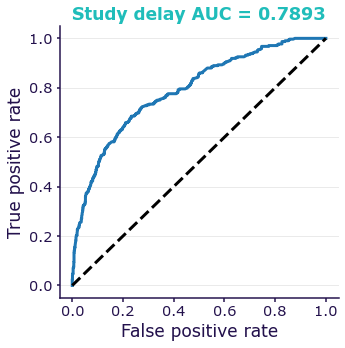

Accuracy score train: 0.8128205128205128
Accuracy score test: 0.8222829801777171
Roc auc score (op y_pred_proba): 0.789312419182549
Roc auc score (op y_pred): 0.6600649350649351
Confusion matrix, without normalization
[[ 117  191]
 [  69 1086]]


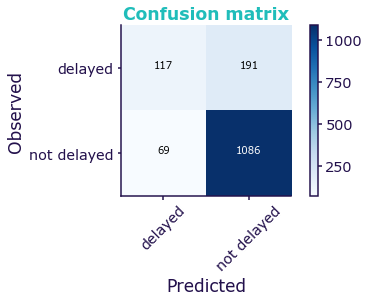

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      1155
           1       0.63      0.38      0.47       308

    accuracy                           0.82      1463
   macro avg       0.74      0.66      0.68      1463
weighted avg       0.80      0.82      0.80      1463



Estimator KNeighborsClassifier
waargenomen [0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 1 0]
voorspelling [0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1]
probability [0.  0.2 0.  0.  0.6 0.2 0.2 0.6 0.2 0.2 0.4 0.4 0.  0.2 0.2 0.4 0.2 0.4
 0.2 0.6]


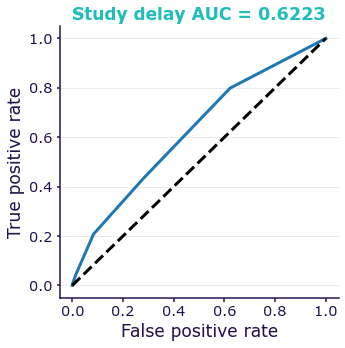

Accuracy score train: 0.8191452991452991
Accuracy score test: 0.7669172932330827
Roc auc score (op y_pred_proba): 0.6222578287513353
Roc auc score (op y_pred): 0.5619047619047619
Confusion matrix, without normalization
[[  64  244]
 [  97 1058]]


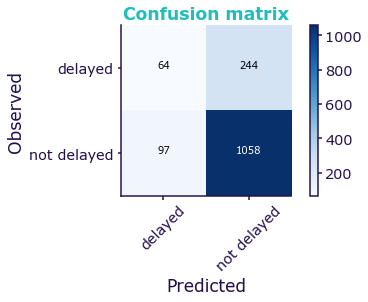

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1155
           1       0.40      0.21      0.27       308

    accuracy                           0.77      1463
   macro avg       0.61      0.56      0.57      1463
weighted avg       0.73      0.77      0.74      1463



Estimator DecisionTreeClassifier
waargenomen [0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 1 0]
voorspelling [0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 1]
probability [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1.]


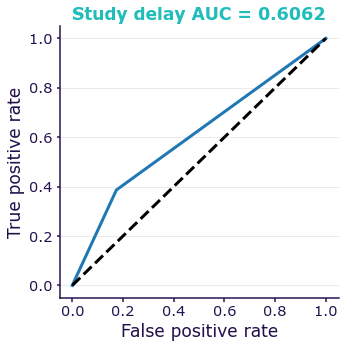

Accuracy score train: 0.9994871794871795
Accuracy score test: 0.7334244702665755
Roc auc score (op y_pred_proba): 0.6061688311688311
Roc auc score (op y_pred): 0.6061688311688311
Confusion matrix, without normalization
[[119 189]
 [201 954]]


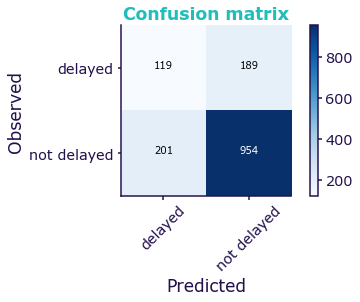

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1155
           1       0.37      0.39      0.38       308

    accuracy                           0.73      1463
   macro avg       0.60      0.61      0.60      1463
weighted avg       0.74      0.73      0.74      1463



Estimator MLPClassifier
waargenomen [0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 1 0]
voorspelling [0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1]
probability [0.   0.2  0.   0.06 0.21 0.12 0.39 0.75 0.43 0.62 0.66 0.13 0.08 0.25
 0.4  0.26 0.33 0.1  0.42 0.58]


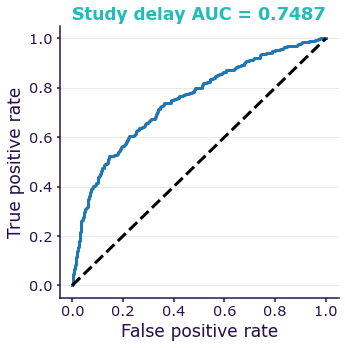

Accuracy score train: 0.7876923076923077
Accuracy score test: 0.7833219412166781
Roc auc score (op y_pred_proba): 0.7486703772418059
Roc auc score (op y_pred): 0.6794372294372294
Confusion matrix, without normalization
[[154 154]
 [163 992]]


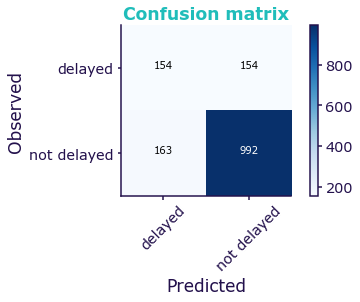

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1155
           1       0.49      0.50      0.49       308

    accuracy                           0.78      1463
   macro avg       0.68      0.68      0.68      1463
weighted avg       0.79      0.78      0.78      1463



Estimator GaussianNB
waargenomen [0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 1 0]
voorspelling [0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0 1 1]
probability [0.   0.16 0.   0.07 0.13 0.4  0.66 0.88 0.66 0.72 0.86 0.21 0.08 0.38
 0.45 0.12 0.55 0.1  0.5  0.68]


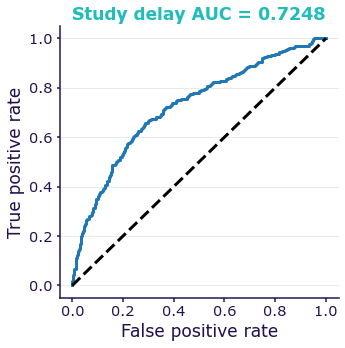

Accuracy score train: 0.7398290598290598
Accuracy score test: 0.7409432672590567
Roc auc score (op y_pred_proba): 0.7248411761398774
Roc auc score (op y_pred): 0.6692640692640692
Confusion matrix, without normalization
[[168 140]
 [239 916]]


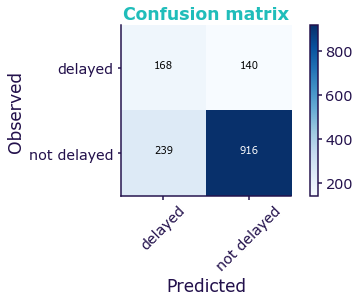

              precision    recall  f1-score   support

           0       0.87      0.79      0.83      1155
           1       0.41      0.55      0.47       308

    accuracy                           0.74      1463
   macro avg       0.64      0.67      0.65      1463
weighted avg       0.77      0.74      0.75      1463



Estimator QuadraticDiscriminantAnalysis
waargenomen [0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 1 0]
voorspelling [0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0 0 1]
probability [0.   0.21 0.   0.08 0.14 0.28 0.79 0.81 0.66 0.68 0.8  0.25 0.13 0.36
 0.36 0.17 0.56 0.21 0.49 0.67]


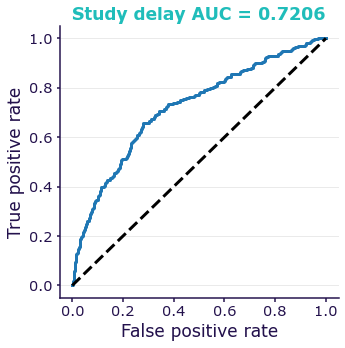

Accuracy score train: 0.7480341880341881
Accuracy score test: 0.7388926862611073
Roc auc score (op y_pred_proba): 0.7205908809804914
Roc auc score (op y_pred): 0.6548701298701299
Confusion matrix, without normalization
[[157 151]
 [231 924]]


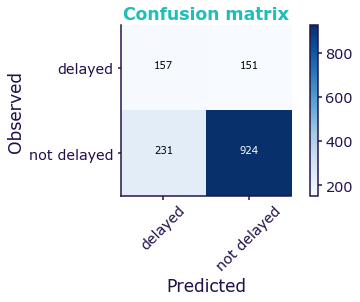

              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1155
           1       0.40      0.51      0.45       308

    accuracy                           0.74      1463
   macro avg       0.63      0.65      0.64      1463
weighted avg       0.76      0.74      0.75      1463





In [27]:
from functies import plot_confusion_matrix, model
for est, name_est in zip(estimators, name_estimators):
    model(df_kenmerken = df_kenmerken, df_label = df_label, est = est, name_est = name_est)


- __Precision__ is a measure of the accuracy provided that a class label has been predicted. Precision = TP / (TP + FP) -> Percentage of predicted delayed students that were true delayed students.

- __Recall__ (or sensitivity) is true positive rate (TPR). Recall =  TP / (TP + FN) -> Percentage of true delayed students that is correctly identified by model. Measure for identifying positives.

- __Specificity__ is true negative rate. Specificity = TN / (TN + FP) -> Percentage of non-delayed students that is correctly identified by model. Measure for identifying negatives. 

- __FPR__ (see roc curves) = False positive rate = 1 - Specificity. FPR = 1 - TN / (TN + FP) OR FPR = FP / (FP + TN) -> Percentage of true non-delayed that is incorrectly identified by model (seen as delayed student).

The F1 score is the harmonic () average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. It is a good way to show that a classifer has a good value for both recall and precision.


And finally, we can tell the average accuracy for this classifier is the average of the F1-score for both labels

#### Per model cross_validation met KFold om te checken dat de test set niet toevallig een "goede" was -> 5 test sets worden vergeleken

In [28]:
from functies import cross_val

for est, name_est in zip(estimators, name_estimators):
    cross_val(df_kenmerken = df_kenmerken, df_label = df_label, est = est, name_est = name_est)

Estimator LogisticRegression


G:\Maarten\Miniconda3\envs\analytics\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
G:\Maarten\Miniconda3\envs\analytics\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

accuracy of each fold - [0.8174982911825017, 0.7826384142173616, 0.8222829801777171, 0.7694938440492476, 0.8071135430916553]
Avg accuracy : 0.7998054145436967

roc_auc (y_pred_prob) of each fold - [0.7648141901388654, 0.7435894157597579, 0.7996019622562456, 0.7713540040708783, 0.7325593767703753]
Avg roc_auc : 0.7623837897992244



Estimator GradientBoostingClassifier
accuracy of each fold - [0.8291182501708817, 0.7928913192071086, 0.8427887901572112, 0.7879616963064295, 0.8276333789329685]
Avg accuracy : 0.8160786869549199

roc_auc (y_pred_prob) of each fold - [0.8069741946365324, 0.7714819777432288, 0.8145167391165191, 0.7964161286697218, 0.773138895199533]
Avg roc_auc : 0.792505587073107



Estimator RandomForestClassifier
accuracy of each fold - [0.8181818181818182, 0.7881066302118934, 0.8291182501708817, 0.7735978112175103, 0.8125854993160054]
Avg accuracy : 0.8043180018196218

roc_auc (y_pred_prob) of each fold - [0.7801371788384776, 0.7391132579167007, 0.7899332530274726, 0.7520

# Beste obv hierboven: GradientBoostingClassifier(random_state = 14)
1. Ik ben gegaan in dit geval voor beste gemiddelde accuracy en roc_auc
1. Let op! Ik heb hierboven geselecteerd op Roc auc score (op y_pred_prob), terwijl hieronder op Roc auc score (op y_pred) is geselecteerd bij het maken van de AUC grafieken per parameter

Estimator GradientBoostingClassifier
waargenomen [0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 1 0]
voorspelling [0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0]
probability [0.06 0.14 0.12 0.04 0.15 0.21 0.38 0.73 0.21 0.68 0.3  0.11 0.12 0.16
 0.1  0.09 0.33 0.11 0.36 0.43]


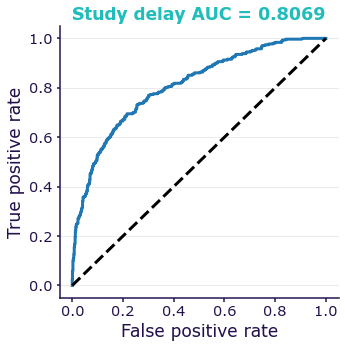

Accuracy score train: 0.8357264957264957
Accuracy score test: 0.8291182501708817
Roc auc score (op y_pred_proba): 0.8069235958846349
Roc auc score (op y_pred): 0.6560606060606061
Confusion matrix, without normalization
[[ 110  198]
 [  52 1103]]


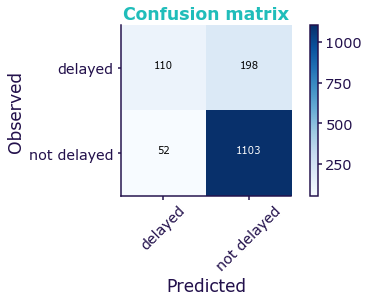

              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1155
           1       0.68      0.36      0.47       308

    accuracy                           0.83      1463
   macro avg       0.76      0.66      0.68      1463
weighted avg       0.81      0.83      0.81      1463





In [29]:
est = GradientBoostingClassifier(random_state = 14)
model(df_kenmerken = df_kenmerken, df_label = df_label, est = est, name_est = "GradientBoostingClassifier")

# Gewichten per kenmerk
1. Let op! Pin1 is hier niet belangrijk, terwijl deze wel een betere correlatie heeft dan ECtmP5. Wanneer je ECtmP5 weglaat krijgt Pin1 het zwaarste gewicht. 

In [30]:
df_gewichten = pd.DataFrame({"Kenmerk": df_kenmerken.columns, "Gewicht": est.feature_importances_}).sort_values('Gewicht', ascending = False)
df_gewichten

,Kenmerk,Gewicht
10,ECtmP5,0.439412
0,Geslacht,0.124869
8,Faculteit,0.091083
7,NaamOpleiding,0.090876
1,Leeftijd,0.075528
3,VooropleidingBRIN4,0.052128
6,DagenTotIngangsdatum,0.051997
4,VooropleidingPC4,0.032614
5,VooropleidingGemCijfer,0.020770
2,Vooropleiding,0.014002


# Parameter tuning stuk voor stuk -> voeg beste parameter tuning steeds toe aan volgende parameter tuning
1. Selecteer waarde waarvoor Avg roc_auc bij cross validatie steeds het hoogst is (omdat je daar 5 test sets gebruikt), dus niet o.b.v. figuur (dat is meer om te laten zien), want we willen niet specifiek voor 1 test-set optimaliseren
1. let op! _pred_prob gebruikt

In [31]:
# standaard parameters
GradientBoostingClassifier().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

# learning_rate = 0.1 

In [32]:
from functies import cross_val2

par_value 1
Avg accuracy : 0.7827149019171482
Avg roc_auc : 0.7340113282638002


par_value 0.5
Avg accuracy : 0.8034990785008785
Avg roc_auc : 0.7651102897435778


par_value 0.25
Avg accuracy : 0.8130700460889819
Avg roc_auc : 0.7864189963574388


par_value 0.1
Avg accuracy : 0.8160786869549199
Avg roc_auc : 0.792505587073107


par_value 0.05
Avg accuracy : 0.8153945054153853
Avg roc_auc : 0.7911537644646451


par_value 0.01
Avg accuracy : 0.7974823578034752
Avg roc_auc : 0.7743437648619504




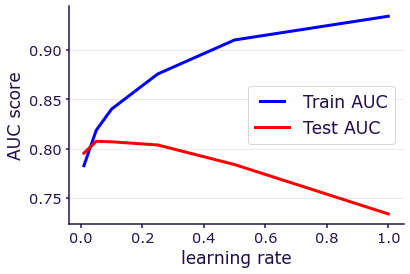

[1, 0.5, 0.25, 0.1, 0.05, 0.01]
[ 0.2   0.13  0.07  0.03  0.01 -0.01]
[0.7337999662674988, 0.7838505650193963, 0.8037119806600326, 0.8069235958846349, 0.8073944453814583, 0.7954151908697362]


In [33]:
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []

# train test split
X_train, X_test, y_train, y_test = train_test_split(df_kenmerken, df_label.values.ravel(), test_size = 0.2, random_state = 14)

for eta in learning_rates:
    est = GradientBoostingClassifier(learning_rate=eta, random_state = 14)
    
    est.fit(X_train, y_train)
    train_pred_prob = est.predict_proba(X_train)[:,1]
    train_results.append(roc_auc_score(y_train, train_pred_prob))
    
    y_pred_prob = est.predict_proba(X_test)[:,1]
    test_results.append(roc_auc_score(y_test, y_pred_prob))

    print ('par_value', eta)
    cross_val2(df_kenmerken = df_kenmerken, df_label = df_label, est = est, name_est = 'GradientBoostingClassifier')
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, train_results, 'b', label='Train AUC')
line2, = plt.plot(learning_rates, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('learning rate')
plt.show()

difference = np.array(train_results) - np.array(test_results)
print(learning_rates)
print(difference)
print(test_results)

# n_estimators = 100

par_value 1
Avg accuracy : 0.7787485752062036
Avg roc_auc : 0.7281015932349458


par_value 2
Avg accuracy : 0.7787485752062036
Avg roc_auc : 0.7472471222808748


par_value 4
Avg accuracy : 0.7787485752062036
Avg roc_auc : 0.7596864285768343


par_value 8
Avg accuracy : 0.7932429008100403
Avg roc_auc : 0.7695331535620606


par_value 16
Avg accuracy : 0.8065068778151072
Avg roc_auc : 0.7790638117126771


par_value 32
Avg accuracy : 0.8127972898294734
Avg roc_auc : 0.787536782918988


par_value 64
Avg accuracy : 0.8143017037681879
Avg roc_auc : 0.7924902026727068


par_value 100
Avg accuracy : 0.8160786869549199
Avg roc_auc : 0.792505587073107


par_value 200
Avg accuracy : 0.812523692018256
Avg roc_auc : 0.7898825410301444




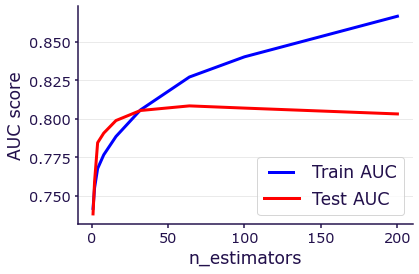

[1, 2, 4, 8, 16, 32, 64, 100, 200]
[ 0.   -0.   -0.02 -0.01 -0.01  0.    0.02  0.03  0.06]
[0.7383932085230785, 0.7593368752459662, 0.7845097543149491, 0.7907305897565637, 0.7988657446449654, 0.8053662787429021, 0.80835582166751, 0.8069235958846349, 0.8031441502220722]


In [34]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []

# train test split
X_train, X_test, y_train, y_test = train_test_split(df_kenmerken, df_label.values.ravel(), test_size = 0.2, random_state = 14)

for estimator in n_estimators:
    est = GradientBoostingClassifier(n_estimators=estimator, 
                                     learning_rate = 0.1,
                                     random_state = 14)
    
    est.fit(X_train, y_train)
    train_pred_prob = est.predict_proba(X_train)[:,1]
    train_results.append(roc_auc_score(y_train, train_pred_prob))
    
    y_pred_prob = est.predict_proba(X_test)[:,1]
    test_results.append(roc_auc_score(y_test, y_pred_prob))

    print ('par_value', estimator)
    cross_val2(df_kenmerken = df_kenmerken, df_label = df_label, est = est, name_est = 'GradientBoostingClassifier')

    from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

difference = np.array(train_results) - np.array(test_results)
print(n_estimators)
print(difference)
print(test_results)

# max_depth = 3

par_value 1
Avg accuracy : 0.811429674796368
Avg roc_auc : 0.7798645443902968


par_value 2
Avg accuracy : 0.8143011427337153
Avg roc_auc : 0.7911003103753438


par_value 3
Avg accuracy : 0.8160786869549199
Avg roc_auc : 0.792505587073107


par_value 4
Avg accuracy : 0.8164890836717461
Avg roc_auc : 0.7889083626038758


par_value 5
Avg accuracy : 0.8100627143034803
Avg roc_auc : 0.7840623277062221


par_value 6
Avg accuracy : 0.805277370768047
Avg roc_auc : 0.7728318018972786




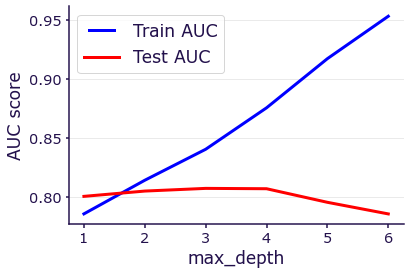

[1, 2, 3, 4, 5, 6]
[-0.01  0.01  0.03  0.07  0.12  0.17]
[0.8001461741721483, 0.8046438410074774, 0.8069235958846349, 0.8066298420194524, 0.7950933265868331, 0.7852420306965762]


In [35]:
max_depths = [1,2,3,4,5,6]
train_results = []
test_results = []

# train test split
X_train, X_test, y_train, y_test = train_test_split(df_kenmerken, df_label.values.ravel(), test_size = 0.2, random_state = 14)

for max_depth in max_depths:
    est = GradientBoostingClassifier(max_depth=max_depth, 
                                     n_estimators = 100, 
                                     learning_rate = 0.1,
                                     random_state = 14)
    
    est.fit(X_train, y_train)
    train_pred_prob = est.predict_proba(X_train)[:,1]
    train_results.append(roc_auc_score(y_train, train_pred_prob))
    
    y_pred_prob = est.predict_proba(X_test)[:,1]
    test_results.append(roc_auc_score(y_test, y_pred_prob))

    print ('par_value', max_depth)
    cross_val2(df_kenmerken = df_kenmerken, df_label = df_label, est = est, name_est = 'GradientBoostingClassifier')
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max_depth')
plt.show()

difference = np.array(train_results) - np.array(test_results)
print(max_depths)
print(difference)
print(test_results)

# min_samples_split = 600

par_value 2
Avg accuracy : 0.8160786869549199
Avg roc_auc : 0.792505587073107


par_value 5
Avg accuracy : 0.8163519107431556
Avg roc_auc : 0.7926287673632457


par_value 50
Avg accuracy : 0.8149846697330316
Avg roc_auc : 0.7928387142789843


par_value 100
Avg accuracy : 0.8149842957100499
Avg roc_auc : 0.7936341965781222


par_value 500
Avg accuracy : 0.8156685707553301
Avg roc_auc : 0.7936310711477597


par_value 600
Avg accuracy : 0.8164888966602553
Avg roc_auc : 0.7941290761238784


par_value 700
Avg accuracy : 0.8155317718497214
Avg roc_auc : 0.7929020549595291




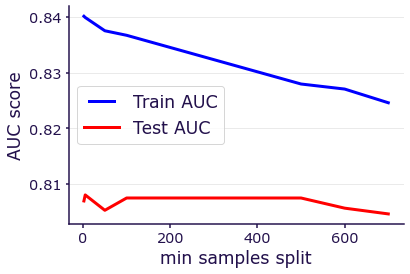

[2, 5, 50, 100, 500, 600, 700]
[0.03 0.03 0.03 0.03 0.02 0.02 0.02]
[0.8069235958846349, 0.808005846966886, 0.8052425929049305, 0.807454882779558, 0.8074520717377861, 0.8056277056277057, 0.8045918367346938]


In [36]:
min_samples_splits = [2,5,50,100,500,600,700]
train_results = []
test_results = []

# train test split
X_train, X_test, y_train, y_test = train_test_split(df_kenmerken, df_label.values.ravel(), test_size = 0.2, random_state = 14)

for min_samples_split in min_samples_splits:
    est = GradientBoostingClassifier(min_samples_split=min_samples_split, 
                                     max_depth = 3, 
                                     n_estimators = 100, 
                                     learning_rate = 0.1,
                                     random_state = 14)
    
    est.fit(X_train, y_train)
    train_pred_prob = est.predict_proba(X_train)[:,1]
    train_results.append(roc_auc_score(y_train, train_pred_prob))
    
    y_pred_prob = est.predict_proba(X_test)[:,1]
    test_results.append(roc_auc_score(y_test, y_pred_prob))

    print ('par_value', min_samples_split)
    cross_val2(df_kenmerken = df_kenmerken, df_label = df_label, est = est, name_est = 'GradientBoostingClassifier')
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

difference = np.array(train_results) - np.array(test_results)
print(min_samples_splits)
print(difference)
print(test_results)

# min_samples_leaf = 1

par_value 1
Avg accuracy : 0.8164888966602553
Avg roc_auc : 0.7941290761238784


par_value 2
Avg accuracy : 0.8164894576947279
Avg roc_auc : 0.7933237730277993


par_value 4
Avg accuracy : 0.8155318653554667
Avg roc_auc : 0.7937792675216203


par_value 8
Avg accuracy : 0.8173097835996532
Avg roc_auc : 0.7934199482602088


par_value 16
Avg accuracy : 0.8155319588612123
Avg roc_auc : 0.7937401488059643


par_value 32
Avg accuracy : 0.815121562144386
Avg roc_auc : 0.7934202998898688


par_value 64
Avg accuracy : 0.8152582675442492
Avg roc_auc : 0.7932074181908355




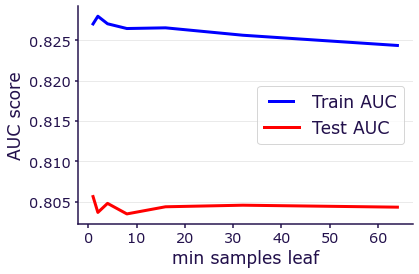

[1, 2, 4, 8, 16, 32, 64]
[0.02 0.02 0.02 0.02 0.02 0.02 0.02]
[0.8056277056277057, 0.8036599763872491, 0.8047843930960814, 0.8034758531511779, 0.8043613313093833, 0.8045566987125429, 0.8043135435992579]


In [37]:
min_samples_leafs = [1,2,4,8,16,32,64]
train_results = []
test_results = []

# train test split
X_train, X_test, y_train, y_test = train_test_split(df_kenmerken, df_label.values.ravel(), test_size = 0.2, random_state = 14)

for min_samples_leaf in min_samples_leafs:
    est = GradientBoostingClassifier(min_samples_leaf=min_samples_leaf, 
                                     min_samples_split = 600, 
                                     max_depth = 3, 
                                     n_estimators = 100, 
                                     learning_rate = 0.1,
                                     random_state = 14)
    
    est.fit(X_train, y_train)
    train_pred_prob = est.predict_proba(X_train)[:,1]
    train_results.append(roc_auc_score(y_train, train_pred_prob))
    
    y_pred_prob = est.predict_proba(X_test)[:,1]
    test_results.append(roc_auc_score(y_test, y_pred_prob))

    print ('par_value', min_samples_leaf)
    cross_val2(df_kenmerken = df_kenmerken, df_label = df_label, est = est, name_est = 'GradientBoostingClassifier')
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

difference = np.array(train_results) - np.array(test_results)
print(min_samples_leafs)
print(difference)
print(test_results)

# max_features = 11

par_value 1
Avg accuracy : 0.8149842022043045
Avg roc_auc : 0.7890140092652551


par_value 3
Avg accuracy : 0.8158050891437025
Avg roc_auc : 0.792284873244377


par_value 9
Avg accuracy : 0.8158049956379569
Avg roc_auc : 0.7924977080760504


par_value 11
Avg accuracy : 0.8164888966602553
Avg roc_auc : 0.7941290761238784




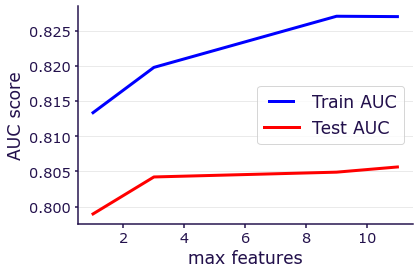

[1, 3, 9, 11]
[0.01 0.02 0.02 0.02]
[0.7989444538145837, 0.8042067240119188, 0.8048898071625344, 0.8056277056277057]


In [38]:
max_features = [1,3,9,11]
train_results = []
test_results = []

# train test split
X_train, X_test, y_train, y_test = train_test_split(df_kenmerken, df_label.values.ravel(), test_size = 0.2, random_state = 14)

for max_feature in max_features:
    est = GradientBoostingClassifier(max_features=max_feature, 
                                     min_samples_leaf = 1, 
                                     min_samples_split = 600, 
                                     max_depth = 3, 
                                     n_estimators = 100, 
                                     learning_rate = 0.1,
                                     random_state = 14)
    
    est.fit(X_train, y_train)
    train_pred_prob = est.predict_proba(X_train)[:,1]
    train_results.append(roc_auc_score(y_train, train_pred_prob))
    
    y_pred_prob = est.predict_proba(X_test)[:,1]
    test_results.append(roc_auc_score(y_test, y_pred_prob))

    print ('par_value', max_feature)
    cross_val2(df_kenmerken = df_kenmerken, df_label = df_label, est = est, name_est = 'GradientBoostingClassifier')
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

difference = np.array(train_results) - np.array(test_results)
print(max_features)
print(difference)
print(test_results)

# Model met beste kenmerken
1. Misschien steeds beste parameter in volgende model stoppen?

Estimator GradientBoostingClassifier
waargenomen [0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 1 0]
voorspelling [0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0]
probability [0.08 0.14 0.08 0.04 0.16 0.19 0.4  0.7  0.19 0.65 0.27 0.11 0.11 0.18
 0.09 0.16 0.32 0.11 0.35 0.43]


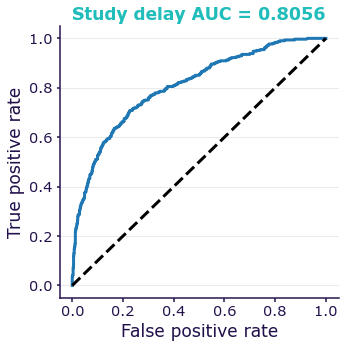

Accuracy score train: 0.8292307692307692
Accuracy score test: 0.8298017771701982
Roc auc score (op y_pred_proba): 0.8056277056277057
Roc auc score (op y_pred): 0.6636363636363637
Confusion matrix, without normalization
[[ 116  192]
 [  57 1098]]


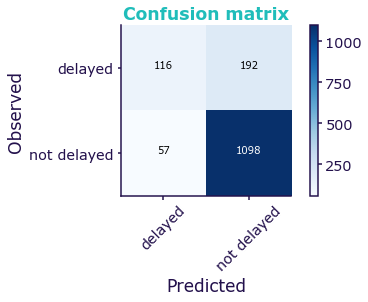

              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1155
           1       0.67      0.38      0.48       308

    accuracy                           0.83      1463
   macro avg       0.76      0.66      0.69      1463
weighted avg       0.81      0.83      0.81      1463





In [39]:
est = GradientBoostingClassifier(learning_rate = 0.1,
                                 n_estimators = 100,
                                 max_depth = 3,
                                 min_samples_split = 600,
                                 min_samples_leaf = 1,
                                 max_features = 11,
                                 random_state = 14)
model(df_kenmerken = df_kenmerken, df_label = df_label, est = est, name_est = "GradientBoostingClassifier")

### Gewichten per kenmerk
1. Let op! Gewichten kunnen anders zijn dan hierboven 
1. Let op! Gewichten zijn gebaseerd op 1 estimator

In [40]:
df_gewichten = pd.DataFrame({"Kenmerk": df_kenmerken.columns, "Gewicht": est.feature_importances_}).sort_values('Gewicht', ascending = False)
df_gewichten

,Kenmerk,Gewicht
10,ECtmP5,0.482255
0,Geslacht,0.126249
8,Faculteit,0.101689
7,NaamOpleiding,0.089324
1,Leeftijd,0.069643
3,VooropleidingBRIN4,0.042237
6,DagenTotIngangsdatum,0.037188
4,VooropleidingPC4,0.024383
2,Vooropleiding,0.013316
5,VooropleidingGemCijfer,0.009758


In [41]:
# Acc is iets hoger en rocauc is iets lager dan 'standaard': let op: optimalisatie ging via cross validation, niet via 'model'
# Accuracy score test: 0.8291182501708817
# Roc auc score (op y_pred_proba): 0.8069235958846349

### Cross_validation

In [42]:
cross_val(df_kenmerken = df_kenmerken, df_label = df_label, est = est, name_est = 'GradientBoostingClassifier')

Estimator GradientBoostingClassifier
accuracy of each fold - [0.8298017771701982, 0.7942583732057417, 0.8421052631578947, 0.7879616963064295, 0.8283173734610123]
Avg accuracy : 0.8164888966602553

roc_auc (y_pred_prob) of each fold - [0.8056277056277057, 0.7717952192946567, 0.8158871760851475, 0.7977360422572145, 0.7795992373546676]
Avg roc_auc : 0.7941290761238784





In [43]:
# Avg accuracy en Avg roc_auc zijn iets hoger dan 'standaard':
# Avg accuracy : 0.8160786869549199
# Avg roc_auc : 0.792505587073107

### Gewichten per kenmerk
1. Let op! Gewichten kunnen anders zijn dan hierboven
1. Let op! Waarschijnlijk worden de gewichten van de laatste estimator van cross_val gebruikt

In [44]:
df_gewichten = pd.DataFrame({"Kenmerk": df_kenmerken.columns, "Gewicht": est.feature_importances_}).sort_values('Gewicht', ascending = False)
df_gewichten

,Kenmerk,Gewicht
10,ECtmP5,0.500432
0,Geslacht,0.112825
8,Faculteit,0.107069
7,NaamOpleiding,0.094103
1,Leeftijd,0.059790
3,VooropleidingBRIN4,0.037975
6,DagenTotIngangsdatum,0.037873
4,VooropleidingPC4,0.017482
9,Pin1,0.012409
5,VooropleidingGemCijfer,0.011840


### O.b.v. RandomizedSearchCV
1. Zoek optimale parameters voor classifier

In [45]:
%%time
#hyperparameter optimization

learning_rate = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
max_depth = [1,2,3,4,5,6]
min_samples_split = [2,5,50,100,500,600,700]
min_samples_leaf = [1,2,4,8,16,32,64]
max_features = [1,3,9,11]


param_grid = {'learning_rate': learning_rate, 'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'max_features': max_features, 'random_state': [14]}

search = RandomizedSearchCV(est, param_grid, n_iter = 100, scoring = make_scorer(roc_auc_score), cv = 5, n_jobs = -1)

search.fit(X_train, y_train) #or full dataset?
#print("score:", search.best_score_)
print("params:", search.best_params_)
#print("est:", search.best_estimator_)
#print("cv results:", search.cv_results_)

params: {'random_state': 14, 'n_estimators': 200, 'min_samples_split': 600, 'min_samples_leaf': 1, 'max_features': 9, 'max_depth': 5, 'learning_rate': 0.25}
CPU times: total: 2 s
Wall time: 53 s


Estimator GradientBoostingClassifier
waargenomen [0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 1 0]
voorspelling [0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 1]
probability [0.03 0.16 0.1  0.03 0.2  0.1  0.58 0.73 0.37 0.79 0.32 0.1  0.15 0.14
 0.09 0.05 0.54 0.09 0.27 0.56]


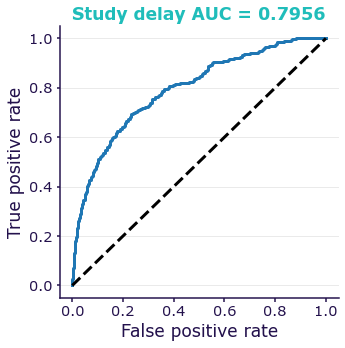

Accuracy score train: 0.8764102564102564
Accuracy score test: 0.8257006151742994
Roc auc score (op y_pred_proba): 0.7956063417102378
Roc auc score (op y_pred): 0.6741341991341993
Confusion matrix, without normalization
[[ 127  181]
 [  74 1081]]


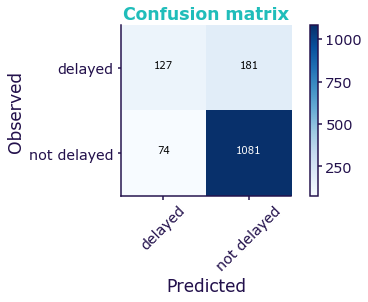

              precision    recall  f1-score   support

           0       0.86      0.94      0.89      1155
           1       0.63      0.41      0.50       308

    accuracy                           0.83      1463
   macro avg       0.74      0.67      0.70      1463
weighted avg       0.81      0.83      0.81      1463





In [46]:
est = GradientBoostingClassifier(learning_rate = 0.25,
                                 n_estimators = 64,
                                 max_depth = 5,
                                 min_samples_split = 50,
                                 min_samples_leaf = 1,
                                 max_features = 3,
                                 random_state = 14)
model(df_kenmerken = df_kenmerken, df_label = df_label, est = est, name_est = "GradientBoostingClassifier")

### Cross_validation

In [47]:
cross_val(df_kenmerken = df_kenmerken, df_label = df_label, est = est, name_est = 'GradientBoostingClassifier')

Estimator GradientBoostingClassifier
accuracy of each fold - [0.8257006151742994, 0.7826384142173616, 0.8291182501708817, 0.7838577291381669, 0.820109439124487]
Avg accuracy : 0.8082848895650393

roc_auc (y_pred_prob) of each fold - [0.7956063417102378, 0.763235414450536, 0.8021071559504895, 0.7739676077971055, 0.7689848937559132]
Avg roc_auc : 0.7807802827328564





In [48]:
# Avg accuracy en Avg roc_auc zijn iets lager dan 'standaard':
# Avg accuracy : 0.8160786869549199
# Avg roc_auc : 0.792505587073107

# Gewichten per kenmerk

In [49]:
df_gewichten = pd.DataFrame({"Kenmerk": df_kenmerken.columns, "Gewicht": est.feature_importances_}).sort_values('Gewicht', ascending = False)
df_gewichten

,Kenmerk,Gewicht
10,ECtmP5,0.258654
9,Pin1,0.104664
6,DagenTotIngangsdatum,0.103563
0,Geslacht,0.102750
7,NaamOpleiding,0.083303
3,VooropleidingBRIN4,0.078088
1,Leeftijd,0.076086
8,Faculteit,0.074644
4,VooropleidingPC4,0.065419
5,VooropleidingGemCijfer,0.033083


# Model-combinatie
1. GradientBoostingClassifier
1. GaussianNB
1. QuadraticDiscriminantAnalysis

In [50]:
est = GradientBoostingClassifier(learning_rate = 0.1,
                                 n_estimators = 100,
                                 max_depth = 3,
                                 min_samples_split = 600,
                                 min_samples_leaf = 1,
                                 max_features = 11,
                                 random_state = 14)
# train test split
X_train, X_test, y_train, y_test = train_test_split(df_kenmerken, 
                                                    df_label.values.ravel(), 
                                                    test_size = 0.2, 
                                                    #stratify = df_label.values.ravel(), 
                                                    random_state = 14)

# model fitten aan train data
est.fit(X_train, y_train)

# train data voorspellen
train_pred = est.predict(X_train)

# y voorspellen op basis van X_test -> het beste model geeft y_test waarden terug
y_pred_GBC = est.predict(X_test)

# kans op y = 0 en y = 1 voorspellen op basis van X_test
y_pred_prob_GBC = est.predict_proba(X_test)[:,1]

# Accuracy -> hoeveel % juist voorspeld?    
print("Accuracy score test:", accuracy_score(y_test, y_pred_GBC))
print("Roc auc score (op y_pred_proba):", roc_auc_score(y_test, y_pred_prob_GBC))

Accuracy score test: 0.8298017771701982
Roc auc score (op y_pred_proba): 0.8056277056277057


In [51]:
est = GaussianNB()
# train test split
X_train, X_test, y_train, y_test = train_test_split(df_kenmerken, 
                                                    df_label.values.ravel(), 
                                                    test_size = 0.2, 
                                                    #stratify = df_label.values.ravel(), 
                                                    random_state = 14)

# model fitten aan train data
est.fit(X_train, y_train)

# train data voorspellen
train_pred = est.predict(X_train)

# y voorspellen op basis van X_test -> het beste model geeft y_test waarden terug
y_pred_GNB = est.predict(X_test)

# kans op y = 0 en y = 1 voorspellen op basis van X_test
y_pred_prob_GNB = est.predict_proba(X_test)[:,1]

# Accuracy -> hoeveel % juist voorspeld?    
print("Accuracy score test:", accuracy_score(y_test, y_pred_GNB))
print("Roc auc score (op y_pred_proba):", roc_auc_score(y_test, y_pred_prob_GNB))

Accuracy score test: 0.7409432672590567
Roc auc score (op y_pred_proba): 0.7248411761398774


In [52]:
est = QuadraticDiscriminantAnalysis()
# train test split
X_train, X_test, y_train, y_test = train_test_split(df_kenmerken, 
                                                    df_label.values.ravel(), 
                                                    test_size = 0.2, 
                                                    #stratify = df_label.values.ravel(), 
                                                    random_state = 14)

# model fitten aan train data
est.fit(X_train, y_train)

# train data voorspellen
train_pred = est.predict(X_train)

# y voorspellen op basis van X_test -> het beste model geeft y_test waarden terug
y_pred_QDA = est.predict(X_test)

# kans op y = 0 en y = 1 voorspellen op basis van X_test
y_pred_prob_QDA = est.predict_proba(X_test)[:,1]

# Accuracy -> hoeveel % juist voorspeld?    
print("Accuracy score test:", accuracy_score(y_test, y_pred_QDA))
print("Roc auc score (op y_pred_proba):", roc_auc_score(y_test, y_pred_prob_QDA))

Accuracy score test: 0.7388926862611073
Roc auc score (op y_pred_proba): 0.7205908809804914


In [53]:
y_pred_prob_GBC[0:10]

array([0.08, 0.14, 0.08, 0.04, 0.16, 0.19, 0.4 , 0.7 , 0.19, 0.65])

In [54]:
y_pred_prob_GNB[0:10]

array([9.85e-40, 1.59e-01, 4.04e-06, 6.87e-02, 1.31e-01, 4.00e-01,
       6.62e-01, 8.75e-01, 6.58e-01, 7.15e-01])

In [55]:
y_pred_prob_QDA[0:10]

array([1.80e-42, 2.13e-01, 5.05e-06, 8.09e-02, 1.43e-01, 2.77e-01,
       7.89e-01, 8.10e-01, 6.62e-01, 6.81e-01])

In [56]:
AVG_y_pred_prob = (y_pred_prob_GBC + y_pred_prob_GNB + y_pred_prob_QDA)/3
AVG_y_pred_prob[0:10]

array([0.03, 0.17, 0.03, 0.06, 0.14, 0.29, 0.62, 0.8 , 0.5 , 0.68])

In [57]:
y_pred_GBC[0:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1])

In [58]:
y_pred_GNB[0:10]

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1])

In [59]:
y_pred_QDA[0:10]

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1])

In [60]:
AVG_y_pred_prob = (y_pred_prob_GBC + y_pred_prob_GNB + y_pred_prob_QDA)/3
AVG_y_pred_prob[0:10]

array([0.03, 0.17, 0.03, 0.06, 0.14, 0.29, 0.62, 0.8 , 0.5 , 0.68])

In [61]:
AVG_y_pred = (y_pred_prob_GBC + y_pred_prob_GNB + y_pred_prob_QDA)/3
AVG_y_pred = np.around(AVG_y_pred)
AVG_y_pred[0:10]

array([0., 0., 0., 0., 0., 0., 1., 1., 1., 1.])

In [62]:
print("Accuracy score test:", accuracy_score(y_test, AVG_y_pred))
print("Roc auc score (op y_pred_proba):", roc_auc_score(y_test, AVG_y_pred_prob))

Accuracy score test: 0.7833219412166781
Roc auc score (op y_pred_proba): 0.7654382414122674


Confusion matrix, without normalization
[[ 145  163]
 [ 154 1001]]


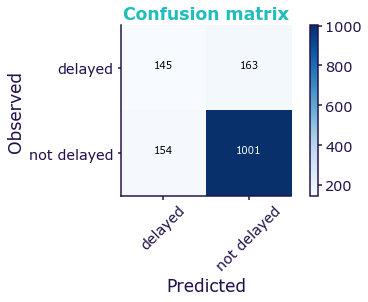

In [63]:
cnf_matrix = confusion_matrix(y_test, AVG_y_pred, labels = [1, 0])
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=['delayed','not delayed'] ,normalize=False,  title='Confusion matrix')
plt.show()

In [64]:
print (classification_report(y_test, AVG_y_pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1155
           1       0.48      0.47      0.48       308

    accuracy                           0.78      1463
   macro avg       0.67      0.67      0.67      1463
weighted avg       0.78      0.78      0.78      1463

